## Clay Minerals

### 1. Data Analysis

In [1]:
import datetime as dt
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
from scipy.stats import mannwhitneyu, ttest_ind

In [42]:
# use science style 
plt.style.use(['science', 'no-latex', 'russian-font'])

sns.set_palette('colorblind')
# sns.set_context('talk')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size':16})

In [21]:
def removeNoize(x: float, 
                acid: str,
                element: str,
               df_control: pd.DataFrame)-> float:
    """
    remove background values for each acid
    
    x: float - value in mmol/l without correction
    acid: str - kind of acid 
    element: str - element to correct
    df_control: pd.DataFrame - df with values for acids
    
    return float: corrected value
    """
    
    mask = df_control['parameter']==acid
    select = df_control.loc[mask, element]
    if len(select) == 0:
        print(acid, element)
    return x - select.values[0]

In [22]:
# start = dt.datetime(year=2022, month=1, day=26)
# end = dt.datetime(year=2022, month=3, day=21)
# delta = 107 + 54

In [23]:
df = pd.read_excel('../data/data_ICP_2021_winter_2022.xlsx', sheet_name='ICP')

dict_AEM = {'Al':26.9,
            'Ca':40,
            'Fe':55.845, 
            'K':39,
            'Mg':24.30, 
            'Si':28}

cols = ['parameter', 'days', 'kind', 'code', 
        'Al', 'Ca', 'Fe', 'K', 'Mg', 'Si']
df = df[cols]


for key, value in dict_AEM.items():
    df.loc[:, key] = df.loc[:, key]/value
    
mask = df['kind']=='control'
df_control = df.loc[mask].copy()
df = df.loc[~mask].copy()
df = df.reset_index(drop=True)


for key, value in dict_AEM.items():
    df.loc[:, key] = df.loc[:, ['parameter', key]].apply(lambda x: removeNoize(x[key], 
                                                                         x['parameter'], 
                                                                         element=key,
                                                                     df_control=df_control), axis=1)

In [24]:
base_concetration = {"ratio_Mg_to_Si": 2.64/3.04, 
                    "ratio_Ca_to_Si": .11/3.04, 
                    "ratio_Fe_to_Si": 0.27/3.04, 
                    "ratio_Al_to_Si": 0.99/3.04,
                    "ratio_K_to_Si": 0.67/3.04,
                    "ratio_K_to_Mg": 0.67/2.64}

In [25]:
for element in ['Al', 'Ca', 'Fe', 'K', 'Mg']:
    df.loc[:, f'ratio_{element}_to_Si'] = df[element]/df['Si']    

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/620202238.py:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


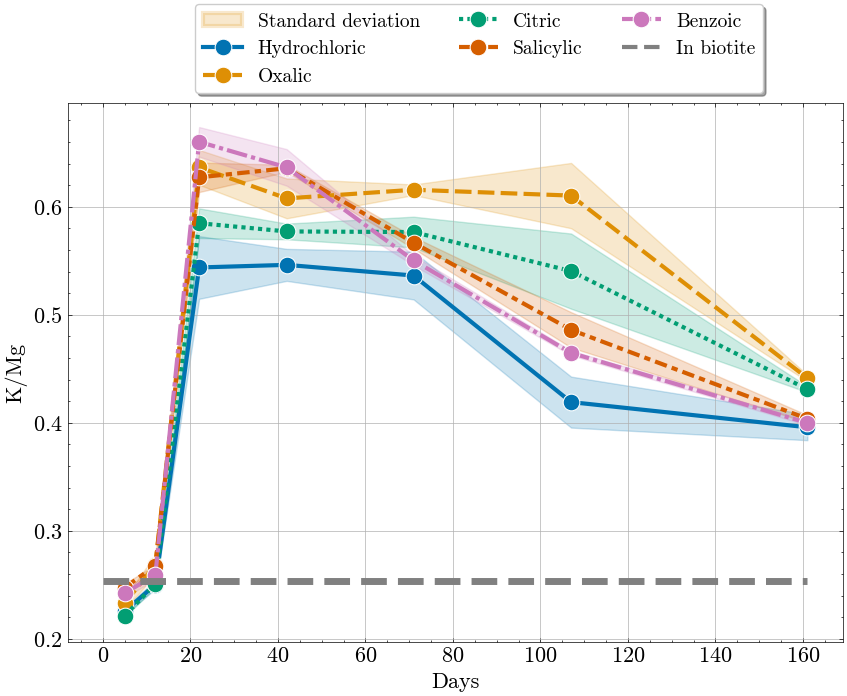

In [26]:
folder = '../plots/acids_elements/'
df.loc[:, f'ratio_K_to_Mg'] = df['K']/df['Mg']
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.lineplot(x='days',
             y='ratio_K_to_Mg',
             marker='o',
             markersize=12, 
             data=df, 
             errorbar='sd',
             estimator='mean',
             style = 'parameter', 
             linewidth = 3,
             hue='parameter',
             ax=ax
            )
ax.grid()
ax.collections[1].set_label('Standard deviation')
ax.hlines(y=base_concetration['ratio_K_to_Mg'], xmin=0, xmax=161, 
          linestyles='dashed', 
          label = 'In biotite', 
         linewidth=5, 
         color='grey', )
leg=ax.legend(frameon=True,           
           bbox_to_anchor=(0.91, 1.2),
           fontsize=14,  
           ncol=3,
           shadow=True,)
# naming = element.split('_')[1] + '/' + element.split('_')[3]
ax.set_ylabel('K/Mg')
ax.set_xlabel('Days')
for i in leg.legendHandles:
    i.set_linewidth(3)
fname = os.path.join(folder, 'K_ratio_Mg'+'.png')
# plt.savefig(fname,  dpi=300)
plt.show()

In [66]:
acid_namer = {'Hydrochloric': 'HCl', 
              'Oxalic':'Щавелевая', 
              'Citric':'Лимонная', 
              'Salicylic': 'Салициловая', 
              'Benzoic': 'Бензойная'}

df['parameter_ru'] = df['parameter'].apply(lambda x: acid_namer[x])

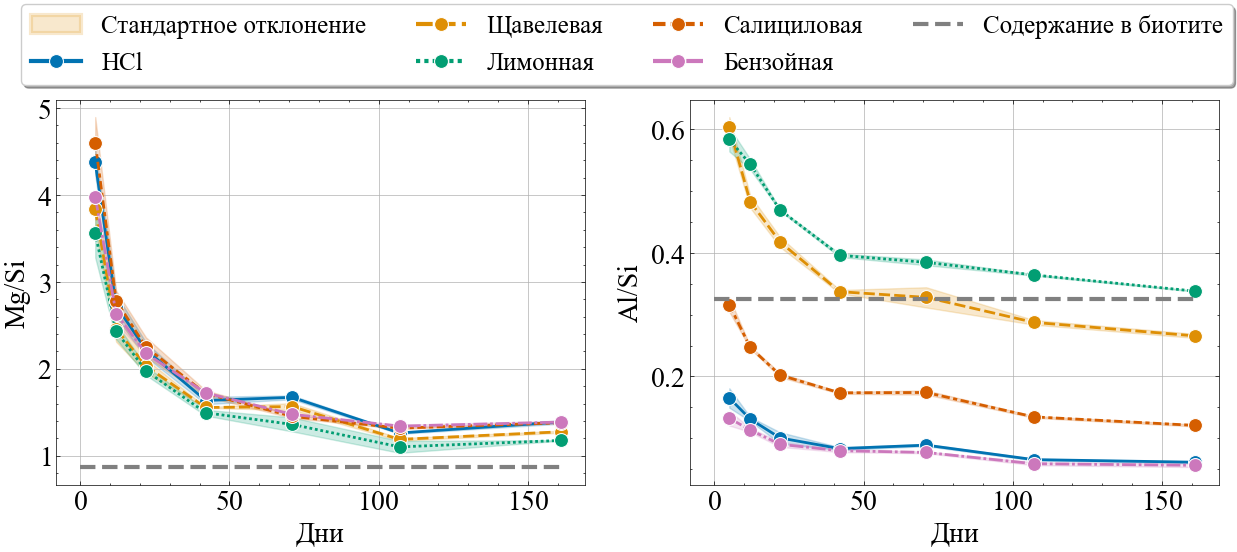

In [135]:


# fig, axes = plt.subplots(3,2, figsize=(12,6))
# axes=axes.flatten()
font_size = 20
plt.rc('axes', titlesize=font_size)
plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
folder = '../plots/acids_elements/'
# ratios=['ratio_Al_to_Si', 'ratio_Ca_to_Si', 'ratio_Fe_to_Si', 'ratio_K_to_Si','ratio_Mg_to_Si']
ratios=['ratio_Mg_to_Si','ratio_Al_to_Si']
annots = ['A','Б']
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes=axes.flatten()
for i, element in enumerate(ratios):
    ax=axes[i]
    # fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=element,
                 marker='o',
                 markersize=10, 
                 data=df, 
                 errorbar='sd',
#                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'parameter_ru', 
                 linewidth = 2,
                 hue='parameter_ru',
                 ax=ax
                )
    
    ax.grid()
    ax.collections[1].set_label('Стандартное отклонение')
    ax.hlines(y=base_concetration[element], xmin=0, xmax=161, 
              linestyles='dashed', 
              label = 'Содержание в биотите',# In biotite 
             linewidth=3, 
             color='grey', )
    if i==1:
        leg=ax.legend(frameon=True,           
                   bbox_to_anchor=(1.05, 1.28),
                   fontsize=18,  
                   ncol=4,
                   shadow=True,)
        for j in leg.legend_handles:
            j.set_linewidth(3)
    else:
        ax.get_legend().remove()

#     leg = ax.legend()
    naming = element.split('_')[1] + '/' + element.split('_')[3]
    ax.set_ylabel(naming, fontsize=font_size)
    ax.set_xlabel('Дни', fontsize=font_size)
    # ax.text(-0.12, 0.92, annots[i], 
    #         fontsize=20,
    #         horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes)
        
    fname = os.path.join(folder, element+'_ru.png')
    # plt.savefig(fname,  dpi=300)
    # plt.show()
    # break
#     break
# plt.tight_layout()
fname = os.path.join(folder, 'Al_Mg_ru_thesis.png')
plt.savefig(fname,  dpi=300)
# plt.show()

In [126]:
i

In [28]:
# sns.set_context('talk')

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/1723580382.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


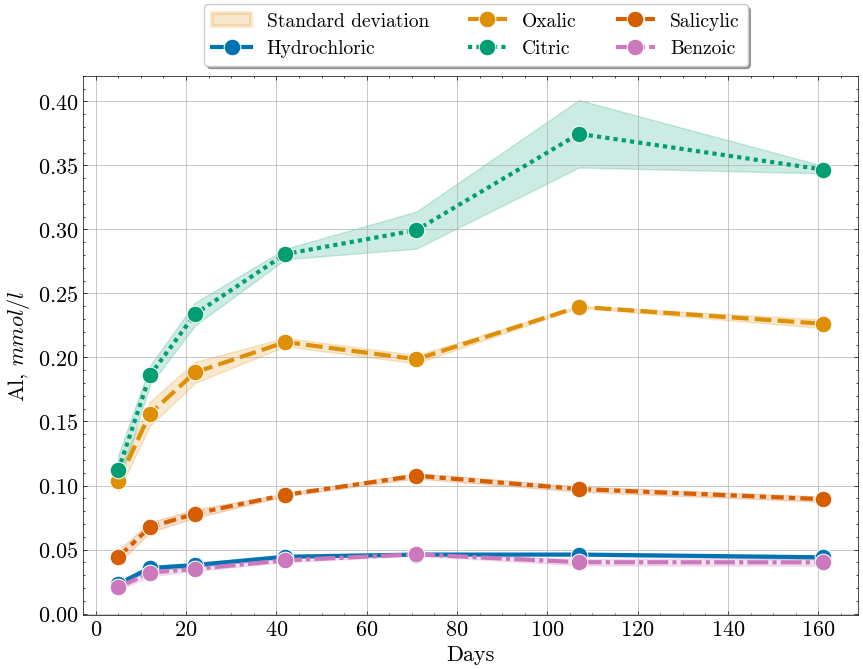

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/1723580382.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


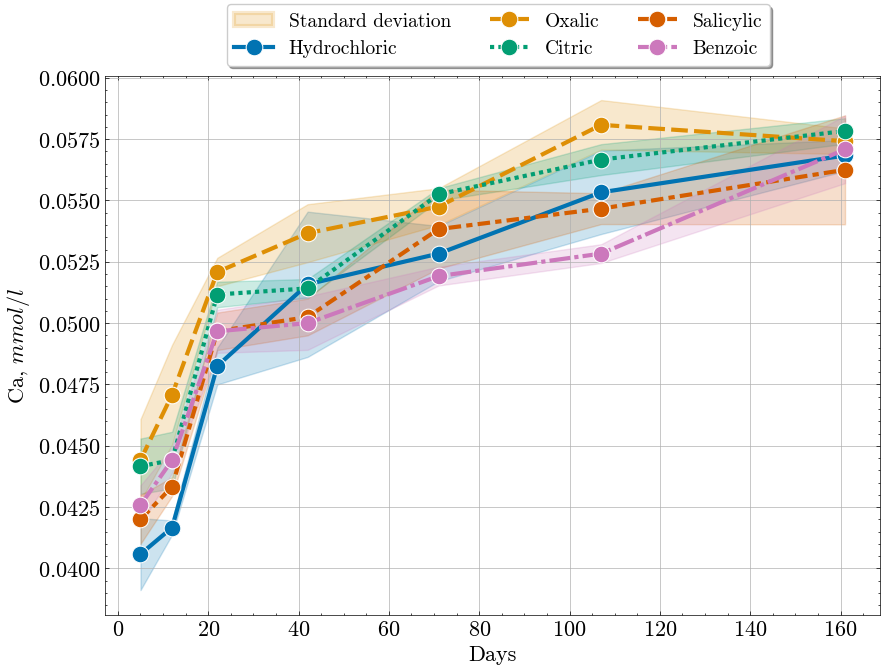

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/1723580382.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


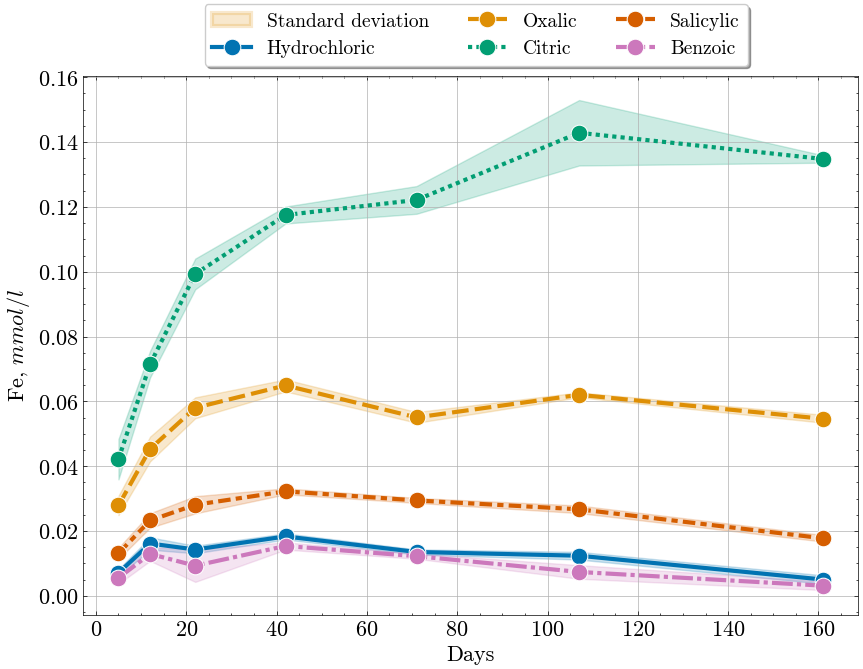

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/1723580382.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


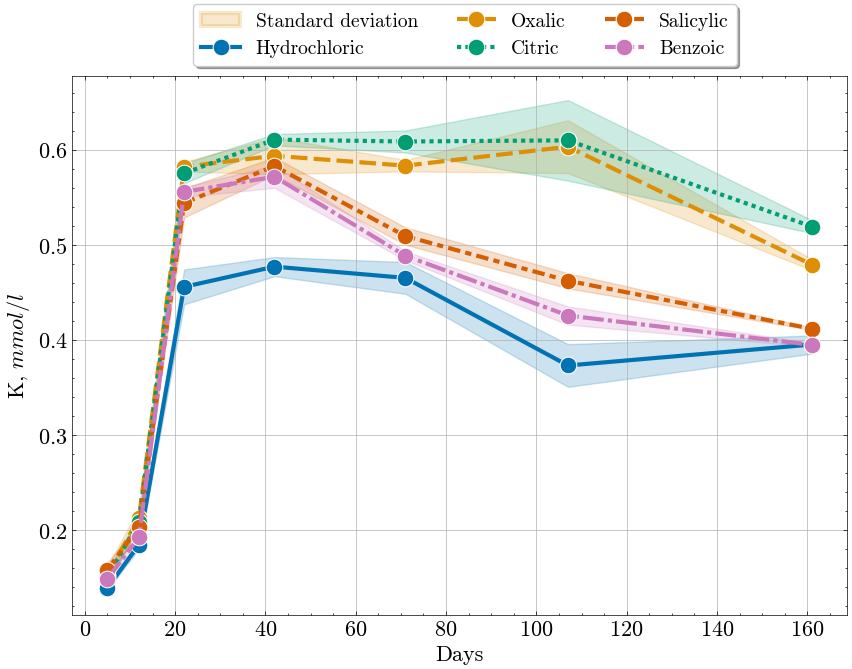

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/1723580382.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


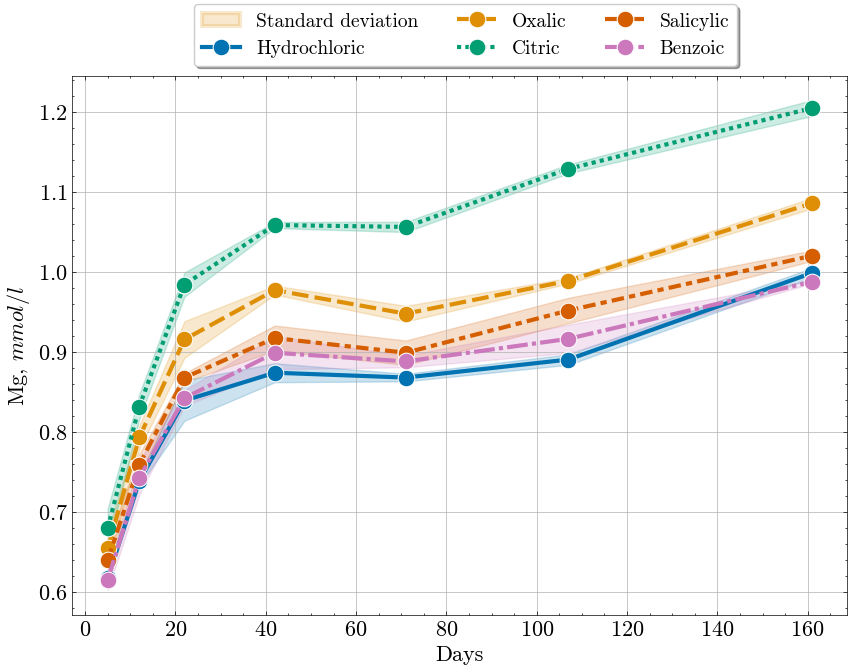

/var/folders/bv/qr4369nx78g7fkr6lx4h5g6r0000gn/T/ipykernel_5599/1723580382.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in leg.legendHandles:


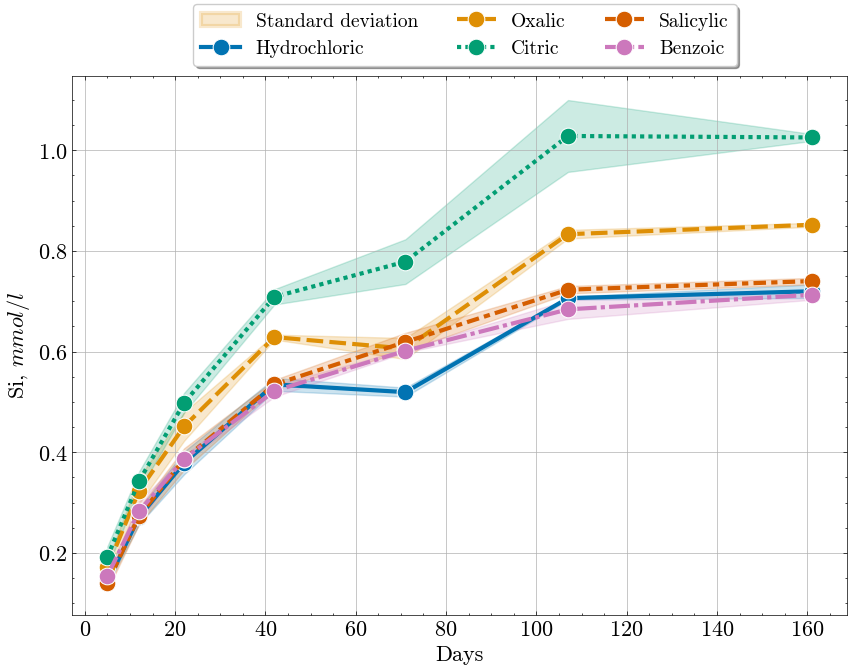

In [29]:


# fig, axes = plt.subplots(3,2, figsize=(12,6))
# axes=axes.flatten()
folder = '../plots/acids_elements/'
elements=['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si']
for i, element in enumerate(elements):
    
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=element,
                 marker='o',
                 markersize=12, 
                 data=df, 
                 errorbar='sd',
#                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'parameter', 
                 linewidth = 3,
                 hue='parameter',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('Standard deviation')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.87, 1.15),
               fontsize=14,  
               ncol=3,
               shadow=True,)
    
#     leg = ax.legend()
    ax.set_ylabel(element+', $mmol/l$')
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(3)
    fname = os.path.join(folder, element+'.png')
#     plt.savefig(fname,  dpi=300)
    plt.show()
#     break
# plt.tight_layout()
# plt.show()

In [10]:
df_melted = pd.melt(df, id_vars= ['parameter', 'days', 'kind'],
        value_vars=['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si'])

In [11]:
mask = df_melted['days']==161
bar_df = df_melted.loc[mask]

In [12]:
mask = (df_melted['parameter']=='Benzoic')&(df_melted['variable']=='Si')
df_melted.loc[mask]

,parameter,days,kind,variable,value
537,Benzoic,5,experiment,Si,0.152571
538,Benzoic,5,experiment,Si,0.154571
539,Benzoic,5,experiment,Si,0.156214
552,Benzoic,12,experiment,Si,0.277607
553,Benzoic,12,experiment,Si,0.265429
554,Benzoic,12,experiment,Si,0.304107
567,Benzoic,22,experiment,Si,0.389000
568,Benzoic,22,experiment,Si,0.390964
569,Benzoic,22,experiment,Si,0.380750
582,Benzoic,42,experiment,Si,0.519607


<AxesSubplot:xlabel='days', ylabel='value'>

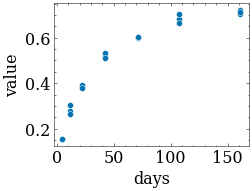

In [13]:
sns.scatterplot(x='days', y='value', data=df_melted.loc[mask])

In [433]:
# df_melted.to_csv('../data/dataset.csv')

In [7]:
# df_melted=pd.read_csv('../data/dataset.csv', index_col=0)

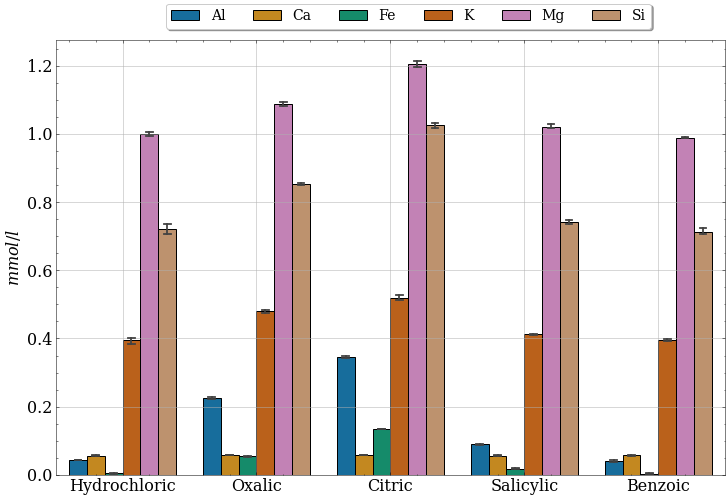

In [14]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.barplot(x='parameter', 
            y='value', 
            hue='variable', 
            data=bar_df,
            edgecolor='k',
            capsize=.05,
            dodge=True,
           ax=ax)
leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.9, 1.1),
               fontsize=14,  
               ncol=6,
               shadow=True,)

ax.grid()
ax.set_ylabel('$mmol/l$')

ax.set_xlabel('')
plt.savefig('../plots/barplots.png', dpi=300)
plt.show()

In [21]:
# import pandas as pd
# import numpy as np
# import scipy.stats as stats
# df=pd.read_csv('https://raw.githubusercontent.com/bilalmussa/st_sig_testing/main/test_control_data.csv')
# group1 = df[df['AnalysisFlag']=='Test']['DP'].to_list()
# group2 = df[df['AnalysisFlag']=='Control']['DP'].to_list()
# s, p = stats.mannwhitneyu(group1, group2, alternative='two-sided')
# print('Statistc: ',s)
# print('P Value: ',p)
# #Statistc: 6966579.5
# #P Value: 0.6559138409860421
# #In this case, there is no significance at any conventional level

Statistc:  6966579.5
P Value:  0.6559138409860421


In [22]:
# data1 = np.random.normal(loc=0, scale=1, size=1000)
# data2 = np.random.normal(loc=0, scale=1, size=1000)
# data3 = np.random.normal(loc=0, scale=1, size=1000)

In [37]:
# for element in bar_df['variable'].unique():
#     data_HCL = bar_df.loc[(bar_df['variable']==element)&(bar_df['parameter']=='Hydrochloric'), 'value']
#     data_benzoic = bar_df.loc[(bar_df['variable']==element)&(bar_df['parameter']=='Salicylic'), 'value']
# #     stat, p = mannwhitneyu(data_HCL, data_benzoic)
    
#     stat, p = stats.ttest_ind(data_HCL, data_benzoic)
#     sns.boxplot(y=data_HCL)
#     sns.boxplot(y=data_benzoic)
#     plt.ylabel(element)
#     plt.show()
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret
#     alpha = 0.05
#     if p > alpha:
#         print('Same distribution (fail to reject H0)', element)
#     else:
#         print('Different distribution (reject H0)', element)

In [38]:
# from scipy.stats import wilcoxon
# # compare samples


# stat, p = wilcoxon(data1, data2)
# sns.kdeplot(x=data1, fill=True)
# sns.kdeplot(x=data2, fill=True)
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# # interpret
# alpha = 0.05
# if p > alpha:
#     print('Same distribution (fail to reject H0)')
# else:
#     print('Different distribution (reject H0)')

In [17]:
!ls ../plots

acids          barplots.png   kinetic_2
acids_elements kinetic_1      phys_chem


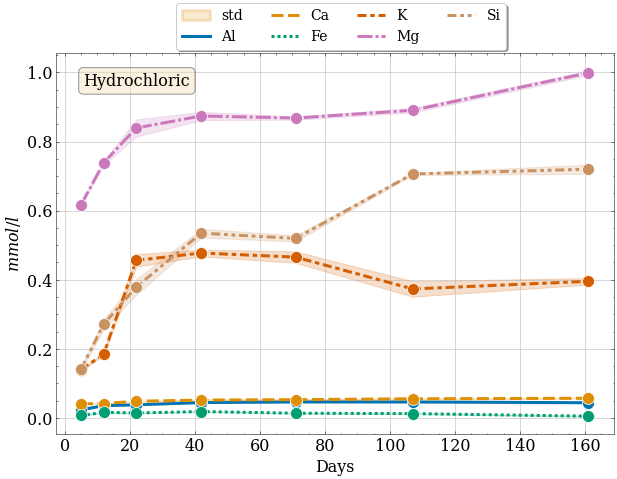

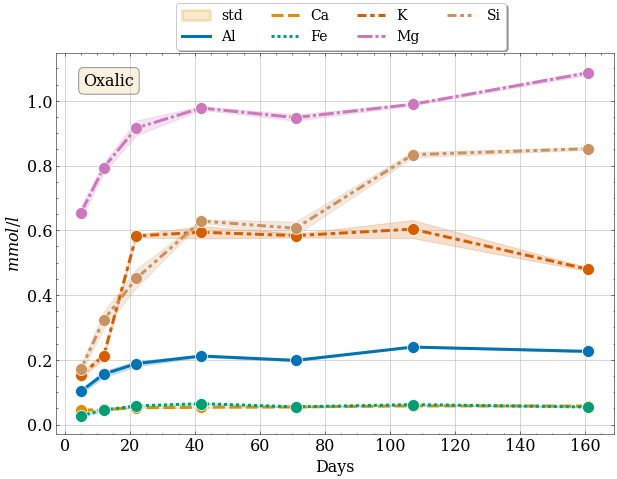

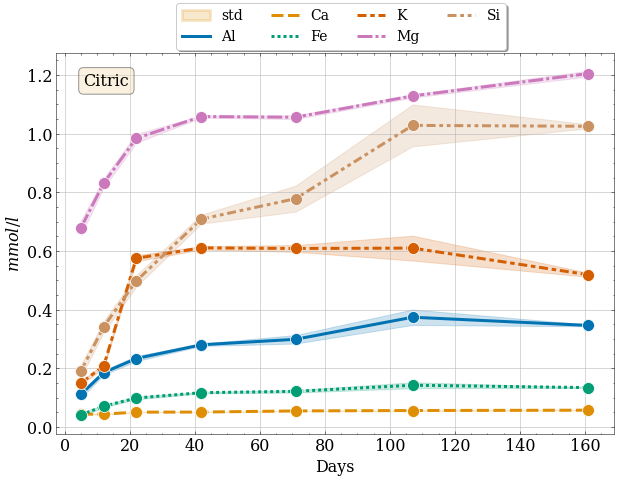

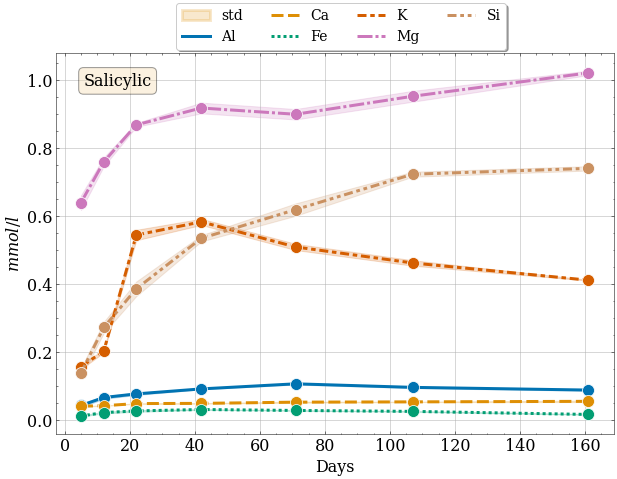

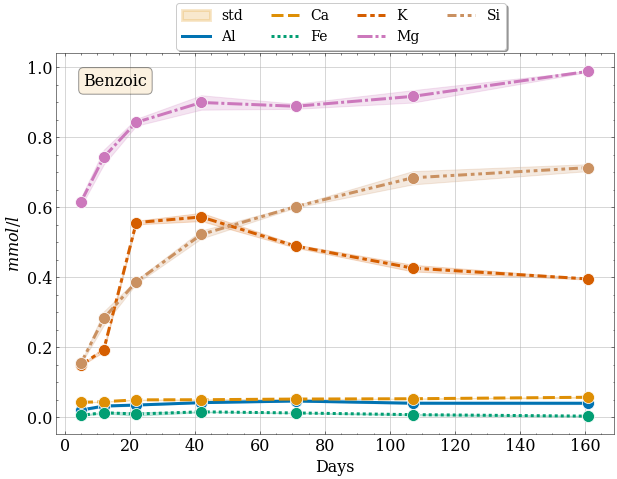

In [18]:


# fig, axes = plt.subplots(3,2, figsize=(12,6))
# axes=axes.flatten()
folder = '../plots/acids/'
acids=['Hydrochloric', 'Oxalic', 'Citric', 'Salicylic', 'Benzoic']
for i, acid in enumerate(acids):
    mask = df_melted['parameter']==acid
    
    acid_df = df_melted.loc[mask]
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y='value',
                 marker='o',
                 markersize=12, 
                 data=acid_df, 
                 errorbar='sd',
#                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'variable', 
                 linewidth = 3,
                 hue='variable',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('std')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.82, 1.15),
               fontsize=14,  
               ncol=4,
               shadow=True,)
    
    ax.set_ylabel('$mmol/l$')
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(3)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
    ax.text(0.05, 0.95, acid, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    fname = os.path.join(folder, acid+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()
#     break
# plt.tight_layout()
# plt.show()

In [40]:
df_ph = pd.read_excel('../data/data_ICP_2021_winter_2022.xlsx', sheet_name='ph_ds')

dict_AEM = {'Al':26.9,
            'Ca':40,
            'Fe':55.845, 
            'K':39,
            'Mg':24.30, 
            'Si':28}

cols = ['code', 'days', 'pH', 'RedOx', 'EC']
df_ph = df_ph[cols]

In [41]:
df_ph=df_ph.merge(df[['parameter', 'code']], on='code', how='left')

In [42]:
mask = df_ph['parameter'].isna()
sel = df_ph.loc[mask].index

In [43]:
df_ph = df_ph.fillna(method='bfill')

In [46]:
df_ph.loc[:, 'RedOx'] = df_ph.loc[:, 'RedOx']+202

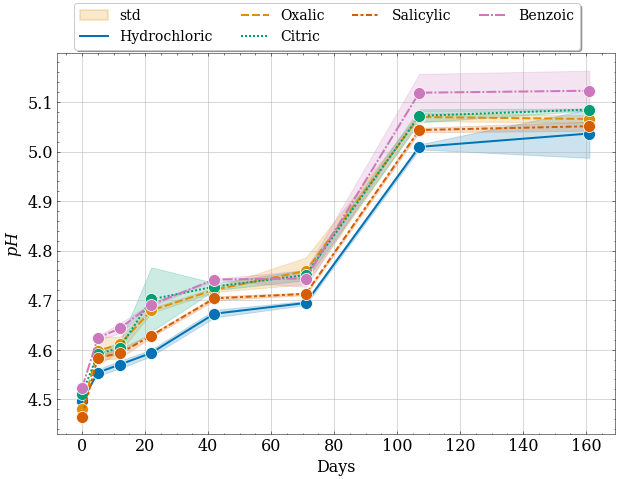

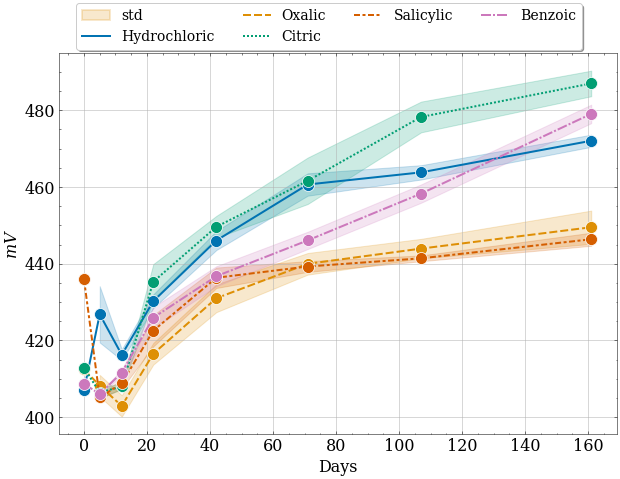

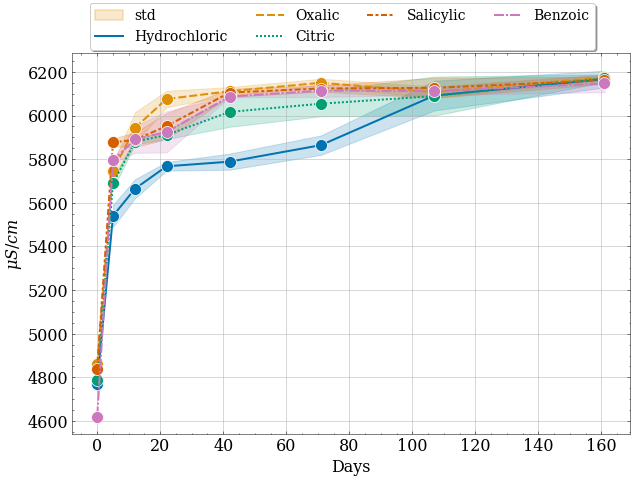

In [48]:
folder = '../plots/phys_chem/'
units = {'pH':'$pH$', 
         "RedOx": "$mV$", 
         'EC': "${\mu}S/cm$" }
for prp in ['pH', "RedOx", 'EC']:
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    sns.lineplot(x='days',
                 y=prp,
                 marker='o',
                 markersize=12, 
                 data=df_ph, 
                 ci='sd',
    #                  ci = ('ci', 0.95), 
                 estimator='mean',
                 style = 'parameter', 
                 linewidth = 2,
                 hue='parameter',
                 ax=ax
                )
    ax.grid()
    ax.collections[1].set_label('std')
    leg=ax.legend(frameon=True,           
               bbox_to_anchor=(0.95, 1.15),
               fontsize=14,  
               ncol=4,
               shadow=True,)

    ax.set_ylabel(units[prp])
    ax.set_xlabel('Days')
    for i in leg.legendHandles:
        i.set_linewidth(2)

    fname = os.path.join(folder, prp+'.png')
    plt.savefig(fname,  dpi=300)
    plt.show()


### End